<a href="https://colab.research.google.com/github/adedoyin-a/water-pollution-prediction/blob/Prediction-with-Prophet/Water_Quality_Time_Series_Forecasting_with_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import libraries and dependencies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore')

from google.colab import files
uploaded = files.upload()



Saving Beach_Water_Quality_-_Automated_Sensors_20250404.csv to Beach_Water_Quality_-_Automated_Sensors_20250404.csv


count    43744.000000
mean         5.898775
std         31.900118
min          0.000000
25%          0.740000
50%          1.350000
75%          2.940000
max       1683.480000
Name: Turbidity, dtype: float64


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1fkefdyp/n32ul2dg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1fkefdyp/52i52air.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66413', 'data', 'file=/tmp/tmp1fkefdyp/n32ul2dg.json', 'init=/tmp/tmp1fkefdyp/52i52air.json', 'output', 'file=/tmp/tmp1fkefdyp/prophet_modely8oizm7f/prophet_model-20250501171633.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:16:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:16:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


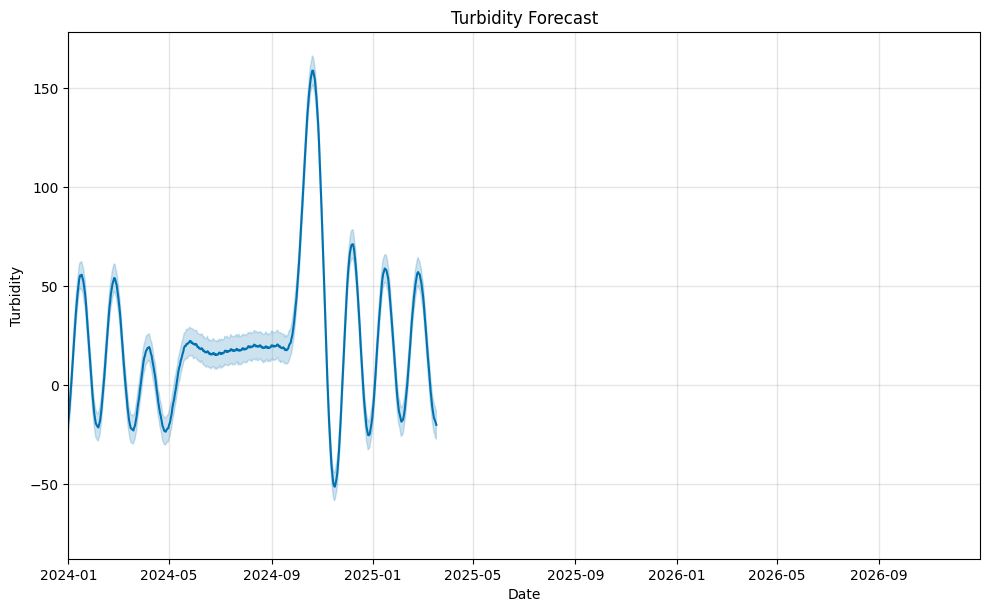

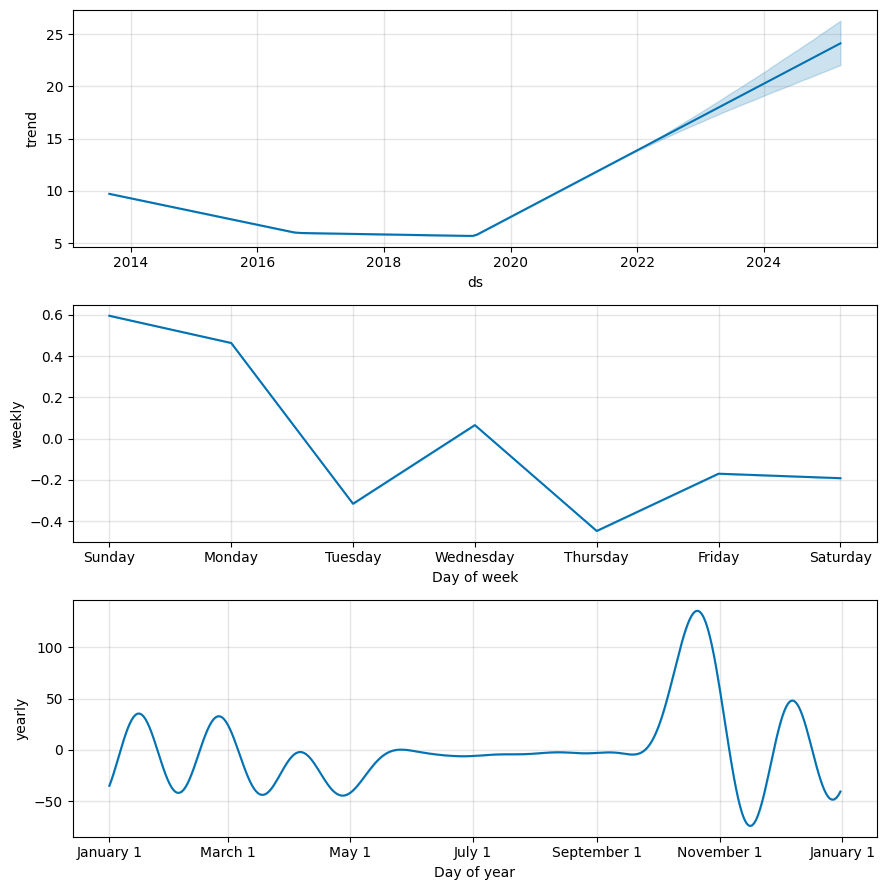

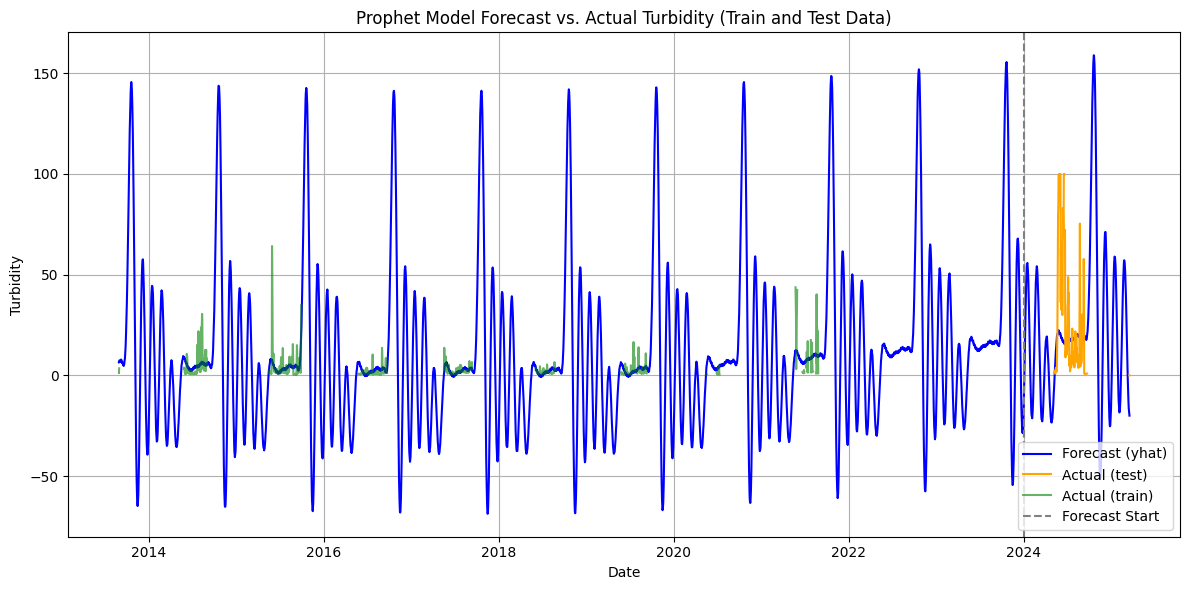

MAE: 19.869
RMSE: 28.433
R² Score: -0.004
count    43744.000000
mean         4.787717
std         12.662975
min          0.000000
25%          0.740000
50%          1.350000
75%          2.940000
max        100.000000
Name: Turbidity, dtype: float64


In [40]:
# Load and preprocess data

df = pd.read_csv('Beach_Water_Quality_-_Automated_Sensors_20250404.csv')

# Remove invalid turbidity values immediately
df = df[df['Turbidity'] >= 0]

print(df['Turbidity'].describe())

# drop columns not needed

df = df.drop(['Beach Name', 'Water Temperature', 'Transducer Depth', 'Wave Height', 'Wave Period', 'Battery Life', 'Measurement Timestamp Label', 'Measurement ID'], axis=1, errors='ignore')

#drop rows with missing turbidity
df = df.dropna(subset=['Turbidity'])

# Cap extreme turbidity values to reduce skew
df['Turbidity'] = df['Turbidity'].clip(upper=100)

df.head()

# convert timestamp to date time

df['Measurement Timestamp'] = pd.to_datetime(df['Measurement Timestamp'])

# resample to daily average to reduce noise and improve model's ability to find patterns

df_daily = df.set_index('Measurement Timestamp').resample('D').mean().reset_index()

# Apply log transformation to turbidity (for stabilization)
# df_daily['y_log'] = np.log1p(df_daily['Turbidity'])

# Create Prophet-compatible DataFrame
df_prophet = df_daily[['Measurement Timestamp', 'Turbidity']].rename(
    columns={'Measurement Timestamp': 'ds', 'Turbidity': 'y'}
)

# Split dataset to train and test

train = df_prophet[df_prophet['ds'] < '2024-01-01']
test = df_prophet[df_prophet['ds'] >= '2024-01-01']

# Initialize the Prophet model
model = Prophet(yearly_seasonality=True, seasonality_prior_scale=10.0)

# Fit the model to the data
model.fit(train)

# Predict on test data for the next 2 years

future = model.make_future_dataframe(periods=len(test), freq='D')
forecast = model.predict(future)


# Predict on the full dataset (so we can compare with actuals)
# forecast = model.predict(df_prophet[['ds']])

# Inverse log transformation on the forecast to get back to original scale
# forecast['yhat'] = np.expm1(forecast['yhat'])

# Plot the forecast
fig1 = model.plot(forecast)

ax = fig1.gca()  # Get current axis from Prophet plot

# Set custom x-axis limits safely
ax.set_xlim(pd.to_datetime(['2024-01-01', '2026-12-31']))

plt.title("Turbidity Forecast")
plt.xlabel("Date")
plt.ylabel("Turbidity")
plt.show()

# Plot Trend and seasonality
fig2 = model.plot_components(forecast)
plt.show()

# Merge test values with forecast
merged = forecast.set_index('ds')[['yhat']].join(
    test.set_index('ds')[['y']], how='left'
).reset_index()

# Plot forecast, test and training data

plt.figure(figsize=(12, 6))
plt.plot(merged['ds'], merged['yhat'], label='Forecast (yhat)', color='blue')
plt.plot(merged['ds'], merged['y'], label='Actual (test)', color='orange')
plt.plot(train['ds'], train['y'], label='Actual (train)', color='green', alpha=0.6)

# Highlight the forecast period
plt.axvline(pd.to_datetime('2024-01-01'), color='gray', linestyle='--', label='Forecast Start')

plt.title("Prophet Model Forecast vs. Actual Turbidity (Train and Test Data)")
plt.xlabel("Date")
plt.ylabel("Turbidity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("prophet_forecast_vs_actual.png", dpi=300)
plt.show()

# Evaluate model performance

eval_df = merged.dropna(subset=['y', 'yhat'])

mae = mean_absolute_error(eval_df['y'], eval_df['yhat'])
rmse = np.sqrt(mean_squared_error(eval_df['y'], eval_df['yhat']))
r2 = r2_score(eval_df['y'], eval_df['yhat'])

print("MAE:", round(mae, 3))
print("RMSE:", round(rmse, 3))
print("R² Score:", round(r2, 3))
print(df['Turbidity'].describe())
